### ELEMENTARY TRADING BOT

The below is a start at using 3 machine learning models to create long/short signals in instances where the stock trades in a range. We will look to employ the algorithm during instances defined with the following characteristics:
- Large-cap stocks (they tend to offer ranges intraday that "scalpers" take advantage of. I'm willing to bet an algo can learn how to scalp like those traders or even better.)
- During times of low volatility. Low Volatility is essentially what we mean when we say, "the stock is trading in a range"; when the price action of a stock can be considered "range-bound".  This is typically in the middle of the day when there is less volume in the markets. We can visualize the average volume given time of day later on in this project. 

We will start with the above, keeing it simple.


Our next step is to choose the variables that we will feed the algorithm. Remember that these variables will be based on a stock's Open Low High and Close (OHLC), and Volume, for now...

### TO--DO
Now we determine the stocks of which we'd like to pull the OHLC data.
Let's go with all of the stocks in the NQ and the ES. This should serve as a nice basis for how the type of stocks that we want to deploy our algorithm onto move; ***mega-cap stocks that offer range-bound trading during periods of low volatility.***

### Getting a list of the stocks in the NQ and ES onto a dataframe. 

Let's start with the NQ.

In [1]:
# Import the required libraries
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
from finta import TA

In [2]:
# # Read csv, take a look
# nq_df = pd.read_csv(("../tradingbotmg/resources/nq_stocks.csv"))
# nq_df.head()

# COMMENTING OUT NOW, We will do this later

In [3]:
# # Do the same for the snp 500 symbols
# snp_df = pd.read_csv(("../tradingbotmg/resources/snp_stocks.csv"))
# snp_df.head()

# COMMENTING OUT NOW, We will do this later

In [4]:
# # Save the symbols from each df
# nq_symbols_df = nq_df["Symbol"]
# snp_symbols_df = snp_df["Symbol"]

# # Put dfs together
# snp_nq_symbols_df = pd.concat([nq_symbols_df, snp_symbols_df], axis=0)

# # Drop duplicates
# snp_nq_symbols_df.drop_duplicates(inplace=True)

# # View
# snp_nq_symbols_df

# COMMENTING OUT NOW, We will do this later

In [5]:
# # Convert symbols to a list so that we can feed it into our Alpaca API.
# # Alpaca is where we will access the historical OHLC data needed.

# nq_snp_symbols_list = snp_nq_symbols_df.tolist()

# len(nq_snp_symbols_list)

# COMMENTING OUT NOW, We will do this later

In [ ]:
# # THE FOLLOWING IS WHEN WE CONTINUE WITH MANY STOCKS...
# # THE FOLLOWING NEEDS TO BE ITERATED

# # Rearrange df
# # Separate ticker data

# # WE'LL HAVE TO iterate the below for all stocks in both the SPY and NQ

# AAPL = aapl_msft_df[aapl_msft_df['symbol']=='AAPL'].drop('symbol', axis=1)
# MSFT = aapl_msft_df[aapl_msft_df['symbol']=='MSFT'].drop('symbol', axis=1)

# AAPL.sort_index(inplace=True)
# MSFT.sort_index(inplace=True)

# # Concatenate the ticker DataFrames
# am_df = pd.concat([AAPL, MSFT],axis=1, keys=['AAPL','MSFT'])


# am_df


# # FEATURE CREATION WITH TWO stocks... this is for LATER USE

# # Generate returns from close column with pct_change

# # WILL NEED TO INTERATE
# am_df[("AAPL","actual_returns")] = am_df[("AAPL","close")].pct_change()
# am_df[("MSFT","actual_returns")] = am_df[("MSFT","close")].pct_change()

# # Drop NaN
# am_df = am_df.dropna()

# # Simple Moving Averages
# am_df[("AAPL","AAPL_SMA5")] = TA.SMA(am_df["AAPL"],5)
# am_df[("AAPL","AAPL_SMA10")] = TA.SMA(am_df["AAPL"],10)

# am_df[("MSFT","MSFT_SMA5")] = TA.SMA(am_df["MSFT"],5)
# am_df[("MSFT","MSFT_SMA10")] = TA.SMA(am_df["MSFT"],10)

# # Exponential Moving Averages
# am_df[("AAPL","AAPL_EMA3")] = TA.EMA(am_df["AAPL"],3)

# am_df[("MSFT","MSFT_EMA3")] = TA.EMA(am_df["MSFT"],3)

# # NEEDS TO BE ITERATED!!


# # Create a df with all the indicators for both AAPL and MSFT
# aapl_indicator_df = am_df["AAPL"].drop(["actual_returns"], axis=1)
# msft_indicator_df = am_df["MSFT"].drop(["actual_returns"], axis=1)

# # Save the signal column as our 'y'
# y=am_df["AAPL"]["signal"]

# display(aapl_indicator_df.head())
# display(aapl_indicator_df.tail())

Okay. Now let's set up our alpaca API to get the OHLC data.


### Alpaca API for Historical OHLC Data

In [6]:
# Imports for Alpaca API, .env files, requests
import os
import requests
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi

%matplotlib inline

In [7]:
# Load .env enviroment variables
load_dotenv()

True

In [8]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Verify that Alpaca key and secret were correctly loaded
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [9]:
# Set start and end dates and specify isoformat
# We will start off with on week in the middle of November of this year, 2023.

start_date = pd.Timestamp("2023-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2024-01-17", tz="America/New_York").isoformat()


In [10]:
# Set the tickers
# Test with one for now.
# Later, this is where we will feed in our list of nq/es stocks we created above
tickers = ["AAPL"]

In [11]:
# Set timeframe for Alpaca API
timeframe = "1Min"

In [12]:
# Get historical OHLC data for AAPL
aapl_df = alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

In [13]:
# Display sample data
aapl_df

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2023-01-03 09:00:00+00:00,131.00,131.00,130.28,208,130.28,8174,130.854120,AAPL
2023-01-03 09:01:00+00:00,131.10,131.17,130.87,157,130.87,8820,130.955243,AAPL
2023-01-03 09:02:00+00:00,131.17,131.24,131.17,53,131.18,2112,131.208769,AAPL
2023-01-03 09:03:00+00:00,131.28,131.29,131.19,90,131.19,3888,131.220790,AAPL
2023-01-03 09:04:00+00:00,131.46,131.46,131.28,88,131.28,5984,131.327899,AAPL
...,...,...,...,...,...,...,...,...
2024-01-17 00:55:00+00:00,183.00,183.03,183.00,45,183.03,1224,183.014261,AAPL
2024-01-17 00:56:00+00:00,183.00,183.01,183.00,69,183.01,4641,183.001462,AAPL
2024-01-17 00:57:00+00:00,183.01,183.04,183.01,21,183.04,958,183.030350,AAPL


FOR NOW, we will not include pre-market/after-hours action, but WE WILL in the future.

Now we clean up the AAPL and MSFT dfs we created; put them together. 

In [14]:
# Separate ticker data
AAPL = aapl_df[aapl_df['symbol']=='AAPL'].drop('symbol', axis=1)

In [15]:
AAPL

,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2023-01-03 09:00:00+00:00,131.00,131.00,130.28,208,130.28,8174,130.854120
2023-01-03 09:01:00+00:00,131.10,131.17,130.87,157,130.87,8820,130.955243
2023-01-03 09:02:00+00:00,131.17,131.24,131.17,53,131.18,2112,131.208769
2023-01-03 09:03:00+00:00,131.28,131.29,131.19,90,131.19,3888,131.220790
2023-01-03 09:04:00+00:00,131.46,131.46,131.28,88,131.28,5984,131.327899
...,...,...,...,...,...,...,...
2024-01-17 00:55:00+00:00,183.00,183.03,183.00,45,183.03,1224,183.014261
2024-01-17 00:56:00+00:00,183.00,183.01,183.00,69,183.01,4641,183.001462
2024-01-17 00:57:00+00:00,183.01,183.04,183.01,21,183.04,958,183.030350


In [16]:
# Sort the indexes

AAPL.sort_index(inplace=True)

In [17]:
# # Concatenate the ticker DataFrames
# AAPL = pd.concat([AAPL, MSFT],axis=1, keys=['AAPL','MSFT'])

# # Preview DataFrame
# AAPL

Nice. Now we have the OHLC data here in our workspace, and we can move onto the next step of the process; data cleaning.

### Data Cleaning

Drop NA.

In [18]:
# Drop NA
AAPL = AAPL.dropna()

AAPL

,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2023-01-03 09:00:00+00:00,131.00,131.00,130.28,208,130.28,8174,130.854120
2023-01-03 09:01:00+00:00,131.10,131.17,130.87,157,130.87,8820,130.955243
2023-01-03 09:02:00+00:00,131.17,131.24,131.17,53,131.18,2112,131.208769
2023-01-03 09:03:00+00:00,131.28,131.29,131.19,90,131.19,3888,131.220790
2023-01-03 09:04:00+00:00,131.46,131.46,131.28,88,131.28,5984,131.327899
...,...,...,...,...,...,...,...
2024-01-17 00:55:00+00:00,183.00,183.03,183.00,45,183.03,1224,183.014261
2024-01-17 00:56:00+00:00,183.00,183.01,183.00,69,183.01,4641,183.001462
2024-01-17 00:57:00+00:00,183.01,183.04,183.01,21,183.04,958,183.030350


For 1 minute: Dropping the NaN just took out about 600 rows of data. Did it take out the whole column given the date? That is not good, since if we have the data for one stock at a given minute but not the other, we don't want to throw out that info for the one stock. 

3166 to 2405 rows after dropping NaN.

We will come back to this. Remember, we don't want little things like this from holding us back from implementing this. Just make a note of these little issues and crush them during the next iteration. 

UPDATE 1: With 3 minutes, we start with 1200 rows, then have 1014 after dropping NaN. 

Seems to get better when we zoom out... We will most probably just source better data, however. 


In [20]:
# Now save this cleaned dataframe to a new .csv
AAPL.to_csv('../algotrader/Resources/aapl_OHLCV_1min_df.csv', index="True")


Our next step is to generate the features from the data set that we will train our model with. 

[Feature Creation->](/Users/montygash/Desktop/ETAlgo/tradingbot/nn_feature_creation.ipynb)

Now we have the indicators and what we are trying to predict (actual returns). 

We will set the indicators to our 'X' and the actual return as our 'y'.

In this case, we have two different stocks that we are trying to predict.
- AAPL data will be used to predict AAPL actual returns.
- MSFT data will be used to predict MSFT actual returns. 
- Is this how we want the algorithm to be? To only train itself on a particular stock? 
    - No... I want it to be trained on MULTIPLE stocks. So it is trained on both MSFT, AAPL, and even TSLA, AMD, NVDA... and then I deploy it on any stock that I want to deploy it onto. 
    - This is a major issue that I need to resolve. 


Let's just begin by implementing the neural network algorithm on only AAPL.

In [ ]:
# X is the indicator df

X = aapl_indicator_df[:]

NameError: name 'aapl_indicator_df' is not defined

In [ ]:
# We should SHIFT it so that it predicts the minute before.
# Drop the timestamp column with NaN values 
X = X.shift().dropna()

X.head()

,close,high,low,trade_count,open,volume,vwap,AAPL_SMA5,AAPL_SMA10,AAPL_SMA20,AAPL_SMA50,AAPL_SMA200,AAPL_EMA3,AAPL_EMA9,AAPL_EMA20,AAPL_EMA50,AAPL_EMA100
timestamp,,,,,,,,,,,,,,,,,


This begs another question: Do we only need to shift it back one? Since we are using 1 minute candles? Maybe we should be shifting it back more than one one minute bar?... We will revisit this later.


We are trying to predict y, which is whether or not we should buy or sell the stock at that given time.

I was confused and tried to implement by making actual returns be the y, but we actually want to generate signals, where the bot chooses whether to short or long the stock based on the predicted returns during the next 1 minute candle (we will probably revisit the 1-minute candle idea. I'm not sure that we want the bot to send out that many signals. Maybe we train it with different OHLC time-frames)

So the first step in making the bot generate signals is to define when the signal is 1 (buy), and -1(sell).

We want the bot to sell when the expected returns is negative, and buy when positive.

In [ ]:
# Create Signal Column
AAPL[("AAPL","signal")] = 0.0

AAPL["AAPL"].head()

,close,high,low,trade_count,open,volume,vwap,actual_returns,AAPL_SMA5,AAPL_SMA10,AAPL_SMA20,AAPL_SMA50,AAPL_SMA200,AAPL_EMA3,AAPL_EMA9,AAPL_EMA20,AAPL_EMA50,AAPL_EMA100,signal
timestamp,,,,,,,,,,,,,,,,,,,


In [ ]:
# Save the signal column as our 'y'
y=AAPL["AAPL"]["signal"]


### Split the Data into Training set and Testing set

In [ ]:
# Import DateOffset
from pandas.tseries.offsets import DateOffset

In [ ]:
# Set start of training period

training_begin = X.index.min()

# Display training begin date

print(training_begin)

NaT


In [ ]:
# Select ending period for the training data. Let's use 3 days, since we are pulling one week of data to start with.
training_end = X.index.min() + DateOffset(days=3)

# Show training end date
print(training_end)

NaT


So our "starter" model will start on the 13th of November, use November 13th to 16th to train itself, and then it will predict the price action of the last day in the set, November 17th. 

In [ ]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

In [ ]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

Now that we have our train and test sets, we shall standardize the data.

### Standardize the Data

In [ ]:
# Import scaler library
from sklearn.preprocessing import StandardScaler

In [ ]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

ValueError: Found array with 0 sample(s) (shape=(0, 17)) while a minimum of 1 is required by StandardScaler.

Now we can implement our machine learning on the scaled data. Let's first use Support Vector Machines, to keep it simple, before we implement the neural networks.

In [ ]:
# Import the SVM model
from sklearn import svm
from sklearn.metrics import classification_report

In [ ]:
# Create the classifier model
svm_model = svm.SVC()

# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[-10:]

array([-1., -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.])

In [ ]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)

# Display report
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.58      0.22      0.32       331
         1.0       0.59      0.88      0.71       429

    accuracy                           0.59       760
   macro avg       0.58      0.55      0.51       760
weighted avg       0.59      0.59      0.54       760



### Backtesting the Algorithm

In [ ]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [ ]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)

# Display the report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.41      1.00      0.58        22
         1.0       0.00      0.00      0.00        32

    accuracy                           0.41        54
   macro avg       0.20      0.50      0.29        54
weighted avg       0.17      0.41      0.24        54



/Users/montygash/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/montygash/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/montygash/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Visually Compare Actual vs Predicted Returns

In [ ]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = AAPL['AAPL']["actual_returns"]

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
timestamp,,,
2023-11-16 21:09:00+00:00,-1.0,-0.000105,0.000105
2023-11-16 21:12:00+00:00,-1.0,0.000791,-0.000791
2023-11-16 21:15:00+00:00,-1.0,0.000527,-0.000527
2023-11-16 21:18:00+00:00,-1.0,-0.000053,0.000053
2023-11-16 21:21:00+00:00,-1.0,0.000842,-0.000842


<Axes: xlabel='timestamp'>

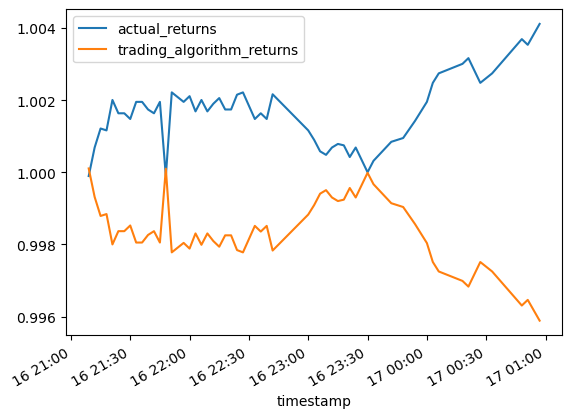

In [ ]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

Looks like our algorithm is missing the point. I wonder if we should go back into the code because we missed something. 

We will do that, but first let's use a different ML model for our predictions and see how different the results are.


In [ ]:
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression


In [ ]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()

# Fit the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)

# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = logistic_regression_model.predict(X_train_scaled)

# Display the predictions
lr_training_signal_predictions

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [ ]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Review the classification report
print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.57      0.23      0.33       331
         1.0       0.59      0.87      0.71       429

    accuracy                           0.59       760
   macro avg       0.58      0.55      0.52       760
weighted avg       0.59      0.59      0.54       760



About the same as the SVM model. 

Time to backtest.

In [ ]:
# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

In [ ]:
# Generate a classification report using the testing data and the logistic regression model's predictions
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Review the testing classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.42      1.00      0.59        22
         1.0       1.00      0.06      0.12        32

    accuracy                           0.44        54
   macro avg       0.71      0.53      0.36        54
weighted avg       0.76      0.44      0.31        54



In [ ]:
# Print the classification report for the SVM model using the test data
print("SVM Classification Report")
print(svm_testing_report)

SVM Classification Report
              precision    recall  f1-score   support

        -1.0       0.41      1.00      0.58        22
         1.0       0.00      0.00      0.00        32

    accuracy                           0.41        54
   macro avg       0.20      0.50      0.29        54
weighted avg       0.17      0.41      0.24        54



In [ ]:
y_train

timestamp
2023-11-13 21:09:00+00:00   -1.0
2023-11-13 21:12:00+00:00    1.0
2023-11-13 21:15:00+00:00   -1.0
2023-11-13 21:18:00+00:00    1.0
2023-11-13 21:21:00+00:00   -1.0
                            ... 
2023-11-16 20:57:00+00:00    1.0
2023-11-16 21:00:00+00:00   -1.0
2023-11-16 21:03:00+00:00   -1.0
2023-11-16 21:06:00+00:00    1.0
2023-11-16 21:09:00+00:00   -1.0
Name: signal, Length: 760, dtype: float64

I guess the SVM model couldn't predict when to buy well... Or there is something wrong with our implementation. How can our recall and f1-score be that low for predicting when to buy, and so high when predicting when to sell? We will revisit this.

Now let's try a basic neural networks model with the same data. 

### Neural Networks Model

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout

In [ ]:
num_predictors = len(X.columns)

# We have a binary outcome, so one output
num_classes = 1

num_predictors

17

In [ ]:
nn_model = Sequential()

In [ ]:
# Add dense layer(s)
nn_model.add(Dense(10, input_dim=num_predictors, activation='relu'))

/Users/montygash/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Drop-out layer(s)
# nn_model.add(Dropout(.2,input_shape=(10,)))

In [ ]:
# Add dense layer, add Regularization
#model.add(Dense(5, activation='relu', kernel_regularized=l2(0.01), bias_regularized=l2(0.01)))

In [ ]:
# Add output layer
# Number of outputs equals number of classes
#nn_model.add(Dense(num_classes))
nn_model.add(Dense(num_classes, activation="sigmoid"))

In [ ]:
# Compile model
nn_model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
# Summarize model
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)                │        180 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 1)                 │         11 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 191 (764.00 B)

 Trainable params: 191 (764.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit model
num_epochs = 50

nn_model.fit(X_train_scaled, y_train,
          epochs=num_epochs,
          batch_size=100,
          validation_split=0.2,     # This 'validation_split' is telling the neural network to keep 20% of the data to validate its score on the training set... this is to help AVOID OVERFITTING. 
          shuffle=True)

Epoch 1/50


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1339 - loss: 0.6654 - val_accuracy: 0.0000e+00 - val_loss: 0.3889
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1469 - loss: 0.6422 - val_accuracy: 0.0000e+00 - val_loss: 0.3420
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1098 - loss: 0.6290 - val_accuracy: 0.0000e+00 - val_loss: 0.3045
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1039 - loss: 0.6135 - val_accuracy: 0.0000e+00 - val_loss: 0.2724
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0922 - loss: 0.5792 - val_accuracy: 0.0000e+00 - val_loss: 0.2437
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0919 - loss: 0.5663 - val_accuracy: 0.0000e+00 - val_loss: 0.2191
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0750 - loss: 0.5713 - val_accuracy: 0.0000e+00 - val_loss: 0.1995
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0607 - loss: 0.5689 - val_accuracy: 0.0000e+00 - val

In [ ]:
# Show model loss and accuracy

# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled, y_test, verbose=2)

# Display the evaluation results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

2/2 - 0s - 6ms/step - accuracy: 0.0000e+00 - loss: 1.8501
Loss: 1.8501321077346802, Accuracy: 0.0


In [ ]:
# Predict values using testing data
nn_test_predictions = nn_model.predict(X_test_scaled)
nn_train_predictions = nn_model.predict(X_train_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


In [ ]:
# Evaluate model using Classification Report

#train_report = classification_report(y_test, )

In [ ]:
# # Save model history for further manipulation
# model_history = model.history.model_history.keys()

In [ ]:
# # Now we can plot the accuracy for training and validation

# training_results = pd.DataFrame(index=range(1, num_epochs+1))
# training_results['Training'] = model_history['categorical_accuracy']
# training_results['Validation'] = model_history['val_categorical_accuracy']
# training_results.plot(title = 'Training and Validation Performance')

First iteration of the neural network model implemented! It is not performing very well, however...

We will come back and fine-tune it, but for right now let's get our model's predictions linked up to Alpaca's trade API so we can execute trades based on the model's decisions.

### Linking to Alpaca Trade API

In [ ]:
# Set signal variable
signal = 1

In [ ]:
# Create buy signal, num shares and ticker
if signal == 1:
    orderSide = "buy"
else:
    orderSide = "sell"

In [ ]:
# Set the ticket symbol and the number of shares to buy
ticker = "AAPL"
number_of_shares = 1

In [ ]:
# # Make API call
# prices = alpaca.get_bars(ticker, "1Min").df

# # Reorganize the DataFrame
# prices = pd.concat([prices], axis=1, keys=["AAPL"])

# # Get final closing price
# limit_amount = prices["AAPL"]["close"][-1]

In [ ]:
# # Submit order
# alpaca.submit_order(
#     symbol="AAPL", 
#     qty=number_of_shares, 
#     side=orderSide, 
#     time_in_force="gtc", 
#     type="limit", 
#     limit_price=limit_amount
# )

deploy. 

Nice! Now I want to take only the necessary portion of this page onto a new .ipynb. We will make it nice and clean. We will only include the data prep portion and the neural networks model. We will keep our comments more breif to improve the readability of the overall idea--the 'gist' of all of the moving parts--from somewhat of a bird's eye view. We will divide the code up strategically, so that we can dive into each moving part and tune it as needed. Our model should become more and more sofisticated and accurate over future iterations until our goal of consistient profitability is met.

[Neural Networks Trading Bot->](neural_networks_trading_bot.ipynb)